<a href="https://colab.research.google.com/github/silviazandoli/explanaible_ai/blob/master/7_Occlusions_cat_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Case 1: Test Occlusion

In [ ]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 761.6 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

In [ ]:
if __name__ == "__main__":
 model = tf.keras.applications.resnet50.ResNet50(
 weights="imagenet", include_top=True
)

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
IMAGE_PATH = "./dog-and-cat-cover.jpg"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH,target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
model.summary()
data = ([img], None)
#indexes from here
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
tabby_cat_class_index = 281
dog = 189
explainer = OcclusionSensitivity()
# Compute Occlusion Sensitivity for patch_size 10
grid = explainer.explain(data, model, tabby_cat_class_index, 10)
explainer.save(grid, ".", "occlusion_sensitivity_10_cat.png")
# Compute Occlusion Sensitivity for patch_size 10
grid = explainer.explain(data, model, dog, 10)
explainer.save(grid, ".", "occlusion_sensitivity_10_dog.png")

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Grad-Cam Example

Explaining Keras image classifier predictions with Grad-CAM

If we have a model that takes in an image as its input, and outputs class scores, i.e. probabilities that a certain object is present in the image, then we can use ELI5 to check what is it in the image that made the model predict a certain class score.

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=6f8f50ac93e0e8251f16a03dc88cfc0632074a9f2c034452d4ddf63618600c6b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

In [ ]:
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

14536120/14536120 [==============================] - 0s 0us/step
(None, 224, 224, 3)
(224, 224)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


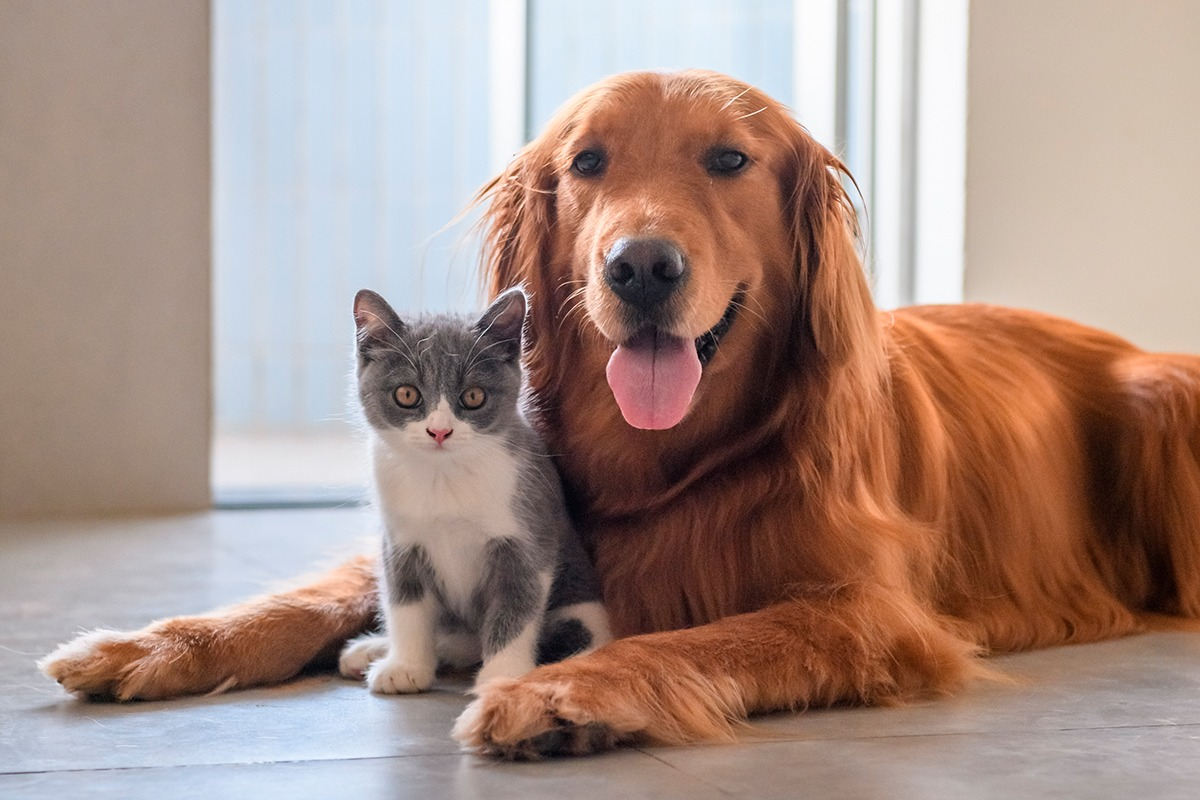

In [ ]:
# we start from a path / URI.
# If you already have an image loaded, follow the subsequent steps
image_uri = 'dog-and-cat-cover.jpg'

# this is the original "cat dog" image used in the Grad-CAM paper
# check the image with Pillow
im = Image.open(image_uri)
print(type(im))
display(im)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7ED6561B8970>


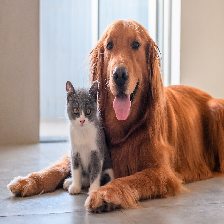

In [ ]:
import keras.utils as image
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
#im=tf.keras.utils.load_img(image_path)
im = keras.utils.load_img(image_uri, target_size=dims) # -> PIL image
print(im)
display(im)

In [ ]:
# we use a routine from `keras.preprocessing` for that as well
# we get a 'doc', an object almost ready to be inputted into the model

doc = tf.keras.utils.img_to_array(im) # -> numpy array
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
# dimensions are looking good
# except that we are missing one thing - the batch size

# we can use a numpy routine to create an axis in the first position
doc = np.expand_dims(doc, axis=0)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


In [ ]:
# `keras.applications` models come with their own input preprocessing function
# for best results, apply that as well

# mobilenetv2-specific preprocessing
# (this operation is in-place)
mobilenet_v2.preprocess_input(doc)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


Explaining our model's prediction

Let’s classify our image and see where the network ‘looks’ when making that classification:

In [ ]:
# make a prediction about our sample image
predictions = model.predict(doc)
print(type(predictions), predictions.shape)

1/1 [==============================] - 3s 3s/step
<class 'numpy.ndarray'> (1, 1000)


In [ ]:
# check the top 5 indices
# `keras.applications` contains a function for that

top = mobilenet_v2.decode_predictions(predictions)
top_indices = np.argsort(predictions)[0, ::-1][:5]

print(top)
print(top_indices)

35363/35363 [==============================] - 0s 0us/step
[[('n02099601', 'golden_retriever', 0.8435774), ('n02100877', 'Irish_setter', 0.015829222), ('n02093991', 'Irish_terrier', 0.011169745), ('n02087394', 'Rhodesian_ridgeback', 0.007057389), ('n02099712', 'Labrador_retriever', 0.0049828673)]]
[207 213 184 159 208]


In [ ]:
# we need to pass the network
# the input as a numpy array
eli5.show_prediction(model, doc)

Tutorial Grad-Cam -> https://eli5.readthedocs.io/en/latest/tutorials/keras-image-classifiers.html

SEE COMPLETE CODE HERE

In [ ]:
# we could use model.summary() here, but the model has over 100 layers.
# we will only look at the first few and last few layers

head = model.layers[:5]
tail = model.layers[-8:]

def pretty_print_layers(layers):
    for l in layers:
        info = [l.name, type(l).__name__, l.output_shape, l.count_params()]
        pretty_print(info)

def pretty_print(lst):
    s = ',\t'.join(map(str, lst))
    print(s)

pretty_print(['name', 'type', 'output shape', 'param. no'])
print('-'*100)
pretty_print([model.input.name, type(model.input), model.input_shape, 0])
pretty_print_layers(head)
print()
print('...')
print()
pretty_print_layers(tail)

name,	type,	output shape,	param. no
----------------------------------------------------------------------------------------------------
input_1,	<class 'keras.engine.keras_tensor.KerasTensor'>,	(None, 224, 224, 3),	0
input_1,	InputLayer,	[(None, 224, 224, 3)],	0
Conv1,	Conv2D,	(None, 112, 112, 32),	864
bn_Conv1,	BatchNormalization,	(None, 112, 112, 32),	128
Conv1_relu,	ReLU,	(None, 112, 112, 32),	0
expanded_conv_depthwise,	DepthwiseConv2D,	(None, 112, 112, 32),	288

...

block_16_depthwise_relu,	ReLU,	(None, 7, 7, 960),	0
block_16_project,	Conv2D,	(None, 7, 7, 320),	307200
block_16_project_BN,	BatchNormalization,	(None, 7, 7, 320),	1280
Conv_1,	Conv2D,	(None, 7, 7, 1280),	409600
Conv_1_bn,	BatchNormalization,	(None, 7, 7, 1280),	5120
out_relu,	ReLU,	(None, 7, 7, 1280),	0
global_average_pooling2d,	GlobalAveragePooling2D,	(None, 1280),	0
predictions,	Dense,	(None, 1000),	1281000


In [ ]:
for l in ['block_2_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument

block_2_expand


block_9_expand


Conv_1


##DeepLift

In [ ]:
# DeepShap using DeepExplainer
# ...include code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
batch_size = 128
num_classes = 10
epochs = 1
# input image dimensions
img_rows, img_cols = 28, 28
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
 x_train = x_train.reshape(x_train.shape[0], 1, img_rows,img_cols)
 x_test = x_test.reshape(x_test.shape[0], 1, img_rows,img_cols)
 input_shape = (1, img_rows, img_cols)
else:
 x_train = x_train.reshape(x_train.shape[0], img_rows,
 img_cols, 1)
 x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
 input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
activation='relu',
input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])
model.fit(x_train, y_train,
batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
469/469 [==============================] - 191s 404ms/step - loss: 2.2834 - accuracy: 0.1634 - val_loss: 2.2601 - val_accuracy: 0.2397
Test loss: 2.2600996494293213
Test accuracy: 0.23970000445842743


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


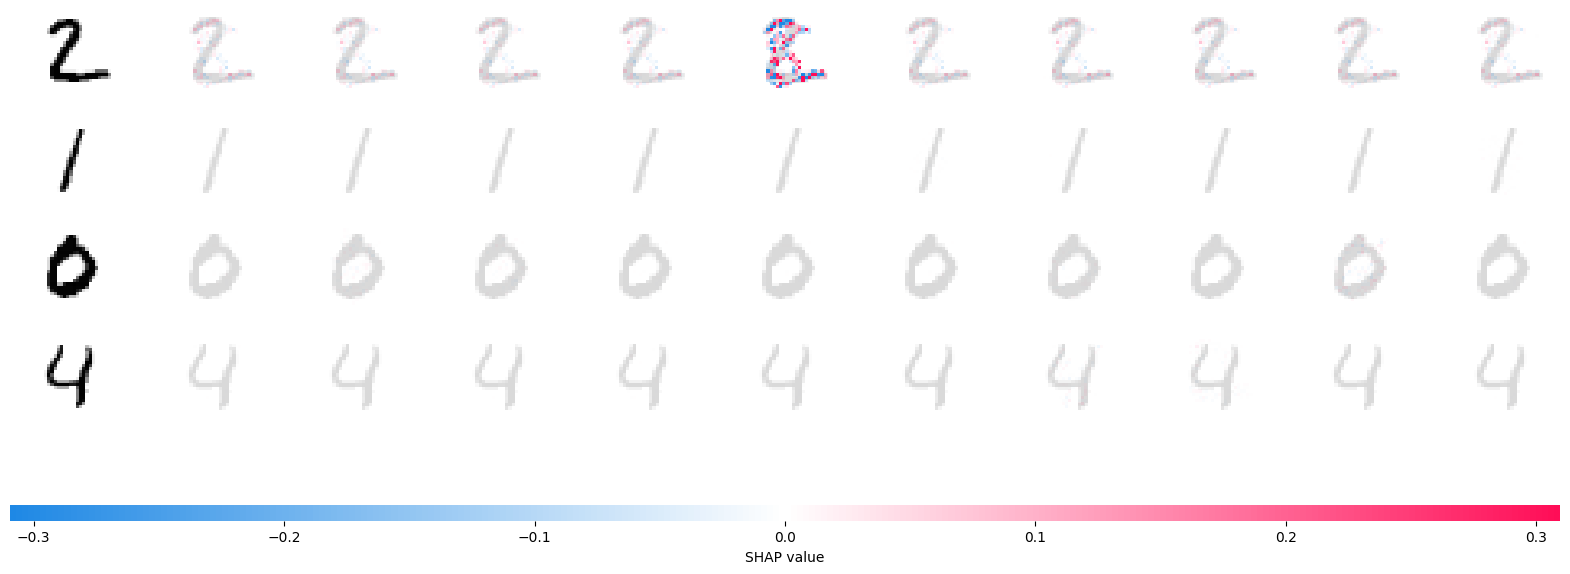

In [ ]:
!pip install shap
#DeepShap using DeepExplainer
import shap
import numpy as np
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100,
replace=False)]
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])
# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

##PCA and Tsne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, decomposition, datasets

In [4]:
digits = datasets.load_digits(n_class=4)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
def plot_lowdim(X, title=None):
 x_min, x_max = np.min(X, 0), np.max(X, 0)
 X = (X - x_min) / (x_max - x_min)
 plt.figure(figsize=(8,6))
 ax = plt.subplot(111)
 for i in range(X.shape[0]):
  plt.text(X[i, 0], X[i, 1], str(y[i]),
color=plt.cm.Set1(y[i] / 10.),
fontdict={'weight': 'bold', 'size': 9})
 plt.xticks([]), plt.yticks([])
 if title is not None:
  plt.title(title)

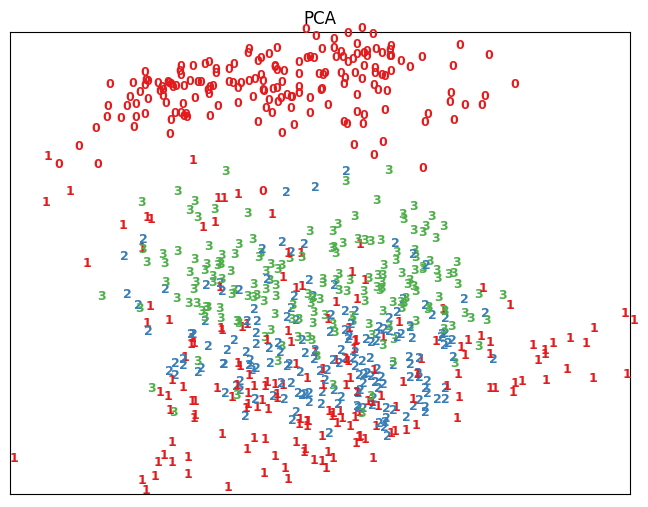

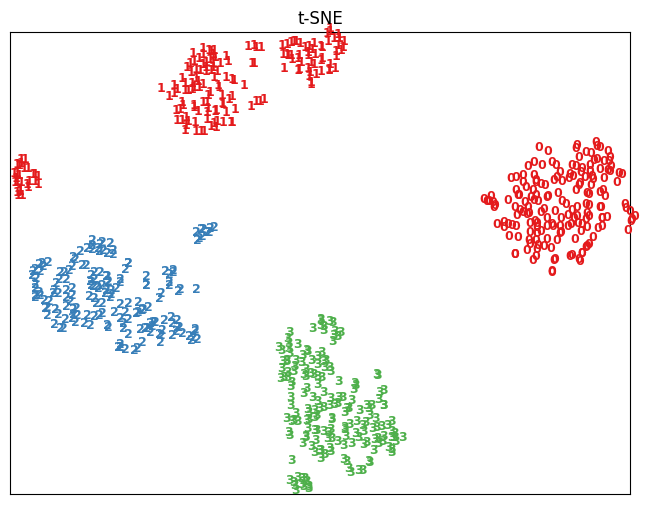

In [5]:
#----------------------------------------------------------------------
# PCA
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_lowdim(X_pca,'PCA')
# t-SNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_lowdim(X_tsne,"t-SNE")
plt.show()

We can see from the images that similar figures are grouped, and intuitively we
can get an idea of how much t-SNE does a better job by leaving a larger space
between the clusters.